# IEL DATA EXPLORATION
This Jupiter notebook is used to explore the data and record my thought process of how I will approach the problem. The first step is to import the necessary libraries, and then load the data.

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import os

### Read in the data
Currently we are using data from the "Carradale Water at Dippen" Water Station. This is a water station which is located in Cambeltown, on the West Coast of Scotland. The reason for choosing this station is because it has approximately the same latitude, and geography as the fictitious island of Claddach and monitors a river pretty much all the way from the source to the river estuary. This means that the data should be representative of the data we would expect to see on Claddach.

The data comes from 4 seperate CSV files which are accessed from the following sources:
- National River Flow Archive (https://nrfa.ceh.ac.uk/data/station/spatial/88001); This is used to get the gauged daily flow and the catchment daily rainfall data.
- River Levels UK (https://riverlevels.uk/carradale-water-dippen#.Y8e3-9LP1hE); This is used to get the daily river level data.
- Scottish Environmental Protection Agency (https://www2.sepa.org.uk/waterlevels/?sd=t&lc=133077); This is used to get recent level data in more detail (quater-hourly opposed to daily, however only for the last 5 days.)

If we decide in the future to model our data using a different water station, we need to ensure that it records all 4 of the CSV files which are mentioned above. Before reading in the data, we took the following steps to format the data so that it is easier to read in and work with:
- Downloaded, renamed, and moved the CSV files to the data folder.
- Removed the first few rows of the CSV files which contained information about the data, and not the data itself.

Improvements which could be made in the future:
- Instead of using just one water station, we could aggregate data from multiple water stations to get a more representative sample of the data.
- Find quater-hourly data for the rainfall and flow data, as this could then be used with the SEPA data to get a more short-term view of the data.
- Find data for extreme weather events, such as floods, to see how the data changes during these events.
- Currently the data time frames have very little overlap (only 2017) which means despite having some data dating back to 1960s we can only use a small portion of it.

In [2]:
# Use numpy to read the 4 csv files into 4 seperate numpy arrays
flow = pd.read_csv('Data/NATIONAL_RIVER_FLOW_ARCHIVE_GAUGED_DAILY_FLOW.csv', error_bad_lines=False) # When reading the csv file, ignore the bad lines
rain = pd.read_csv('Data/NATIONAL_RIVER_FLOW_ARCHIVE_CATCHMENT_DAILY_RAINFALL.csv')
level = pd.read_csv('Data/RIVER_LEVELS_UK.csv')
level_recent = pd.read_csv('Data/SEPA_LEVEL_DATA.csv')


/tmp/ipykernel_10005/4235383111.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  flow = pd.read_csv('Data/NATIONAL_RIVER_FLOW_ARCHIVE_GAUGED_DAILY_FLOW.csv', error_bad_lines=False) # When reading the csv file, ignore the bad lines
Skipping line 62: expected 2 fields, saw 3
Skipping line 63: expected 2 fields, saw 3
Skipping line 64: expected 2 fields, saw 3
Skipping line 65: expected 2 fields, saw 3
Skipping line 66: expected 2 fields, saw 3
Skipping line 67: expected 2 fields, saw 3
Skipping line 68: expected 2 fields, saw 3
Skipping line 69: expected 2 fields, saw 3
Skipping line 70: expected 2 fields, saw 3
Skipping line 71: expected 2 fields, saw 3
Skipping line 72: expected 2 fields, saw 3
Skipping line 73: expected 2 fields, saw 3
Skipping line 74: expected 2 fields, saw 3
Skipping line 75: expected 2 fields, saw 3
Skipping line 76: expected 2 fields, saw 3
Skipping line 77: expected

In [3]:
# Merge the 3 datasets into one - excluding the level_recent dataset as it uses dataTime opposed to just date.
merged = pd.merge(flow, rain, on=['date'])
merged = pd.merge(merged, level, on=['date'])
merged.dropna(inplace=True)
merged = merged.drop('ignore', axis=1)
merged.describe()

# Find the number of days with more than 1mm of rain
merged[merged['cdr(mm)'] > 1].count()

date         123
gdf(m3/s)    123
cdr(mm)      123
min_level    123
avg_level    123
max_level    123
dtype: int64

### Plotting the data
First stage of exploring the data is to create a basic plot to see what the interactions are between the flow, rainfall and river level data. After this, we can start to look at the data in more detail.

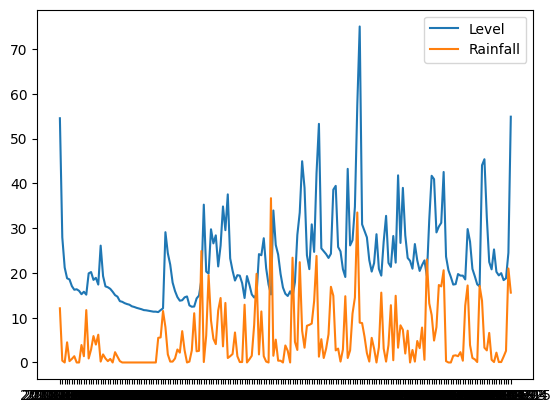

In [4]:
plt.plot(merged['date'], [i * 50 for i in merged['avg_level']])
#plt.plot(merged['date'], merged['gdf(m3/s)'])
plt.plot(merged['date'], merged['cdr(mm)'])
plt.legend(['Level', 'Rainfall'])
plt.show()

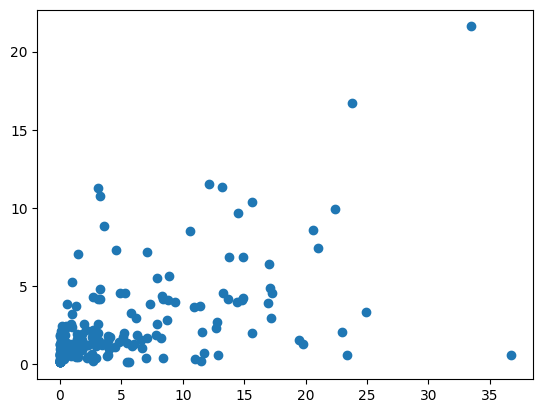

In [5]:
# Sort the data by the average rainfall (independent variable) and plot the average flow and level (dependent variables)
byRainfall = merged.sort_values(by=['cdr(mm)'])
plt.plot(byRainfall['cdr(mm)'], byRainfall['gdf(m3/s)'], 'o')

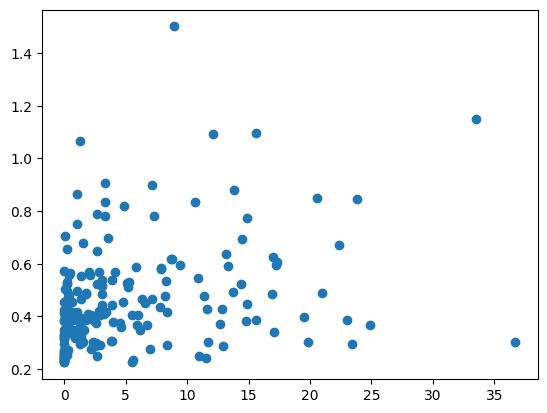

In [6]:
plt.plot(byRainfall['cdr(mm)'], byRainfall['avg_level'], 'o')

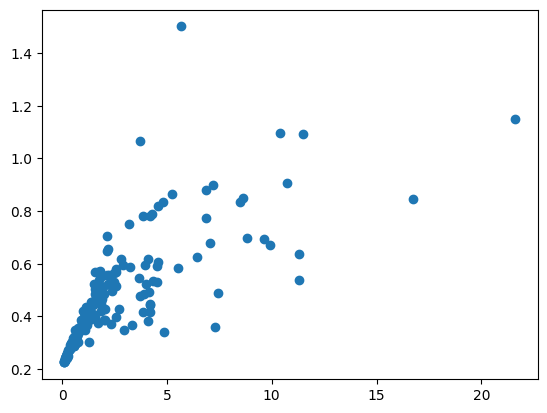

In [7]:
# Attempt to plot average level against average flow
plt.plot(byRainfall['gdf(m3/s)'], byRainfall['avg_level'], 'o')

Text(0.5, 0, 'Rainfall')

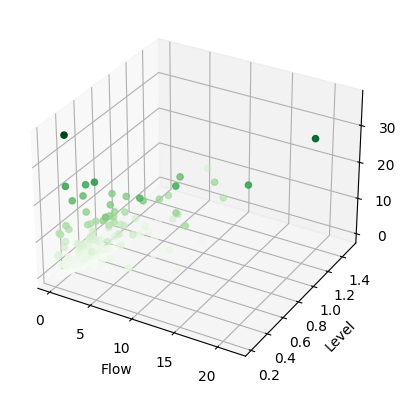

In [8]:
# Plot all 3 variables on a 3D graph
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(byRainfall['gdf(m3/s)'], byRainfall['avg_level'], byRainfall['cdr(mm)'], c=byRainfall['cdr(mm)'], cmap='Greens');
ax.set_xlabel('Flow')
ax.set_ylabel('Level')
ax.set_zlabel('Rainfall')


### Simple Calculations

- The Catchment Area of the Carradale Water at Dippen Water Station is 58.5km^2 (https://www2.sepa.org.uk/waterlevels/default.aspx?sd=t&lc=133077).
- 1mm of rainfall is equal to 1 litre of water per square metre.
- hence the amount of water going into our river (measured in litres) on a given day is equal to: rainfall * 58.5 * 1,000,000 (to convert from km^2 to m^2)
- = rainfall * 58,500,000

- For the amount of water going out of the river (measured in litres) on a given day, we can use the flow data.
- We know that the flow data is measured in m^3/s, so we can convert this to litres (by multiplying by 1000) and then multiply by the number of seconds in a day (86400) to get the litres of water going out of the river on a given day.
- = flow * 1000 * 86400
- = flow * 86,400,000

Hence the water difference on a given day is equal to:
- = rainfall * 58,500,000 - flow * 86,400,000

Let's add this to our dataframe and plot it.


In [9]:
waterDifference = [merged['cdr(mm)'][i]*58500000 - merged['gdf(m3/s)'][i]*86400000 for i in range(len(merged['cdr(mm)']))]
cumulativeWaterDifference = [sum(waterDifference[:i]) for i in range(len(waterDifference))]

print("minimum cumulative water difference:", min(cumulativeWaterDifference))
print("maximum cumulative water difference:",max(cumulativeWaterDifference))
print("mean cumulative water difference:",sum(cumulativeWaterDifference)/len(cumulativeWaterDifference))

minimum cumulative water difference: -573771600.0
maximum cumulative water difference: 18403430400.0
mean cumulative water difference: 8682335809.52381


As can be seen from the above numbers, we seem to be gaining a lot more water than we are losing. This is likely because we made two assumptions when calculating the water difference:
- We assumed that all of the rainfall was eventually going into the river.
- We didn't take avaperation into account.

The Scottish Governments states that the estimated percentage of precipitation which runoffs into the see is approximately 73% (https://www.gov.scot/publications/scotlands-marine-atlas-information-national-marine-plan/pages/7/) However, this is extremely variable from location to location (eg. in the USA this is as low as 30% (https://www.usgs.gov/special-topics/water-science-school/science/rain-and-precipitation). As well as the fact that on a daily, or even hourly basis, this will depend upon the weather conditions as more sunshine and warmer weather will lead to more evaporation and less ending up in the river. Therefore for now, we will set the percentage of rainfall which ends up in the river to a figure which results in the cumulative water difference throughout the year being equal to 0. This will likely be changed later to a more realistic value which changes throughout the year to account for the weather conditions.

In [10]:
# To find the percentage that makes the culmulative water difference the closest to 0 we will use a binary search algorithm, starting with a percentage of 0.5.
percentage = 0.5
scale = 0.5
waterDifference = [merged['cdr(mm)'][i]*58500000*percentage - merged['gdf(m3/s)'][i]*86400000 for i in range(len(merged['cdr(mm)']))]
cumulativeWaterDifference = [sum(waterDifference[:i]) for i in range(len(waterDifference))]
averageCum = sum(cumulativeWaterDifference)/len(cumulativeWaterDifference)

while (averageCum >= 100 or averageCum <= -100):
    waterDifference = [merged['cdr(mm)'][i]*58500000*percentage - merged['gdf(m3/s)'][i]*86400000 for i in range(len(merged['cdr(mm)']))]
    cumulativeWaterDifference = [sum(waterDifference[:i]) for i in range(len(waterDifference))]
    averageCum = sum(cumulativeWaterDifference)/len(cumulativeWaterDifference)
    if averageCum >= 100:
        percentage -= scale
    elif averageCum <= -100:
        percentage += scale
    scale /= 2


print("Calculated percentage of water which ends up in river", percentage)

waterDifference = [merged['cdr(mm)'][i]*58500000*percentage - merged['gdf(m3/s)'][i]*86400000 for i in range(len(merged['cdr(mm)']))]
cumulativeWaterDifference = [sum(waterDifference[:i]) for i in range(len(waterDifference))]

print("\nminimum cumulative water difference:", min(cumulativeWaterDifference))
print("maximum cumulative water difference:",max(cumulativeWaterDifference))
print("mean cumulative water difference:",sum(cumulativeWaterDifference)/len(cumulativeWaterDifference))

Calculated percentage of water which ends up in river 0.647256925702095

minimum cumulative water difference: -2755894926.9117584
maximum cumulative water difference: 3399227564.6629395
mean cumulative water difference: 85.47251271696949


The final calculated percentage of water which ends up in the river is 64.7%, which is fairly close to the Scotish Governments stated estimate of 73%. In the future we could look at using a more accurate value for this, or even a value which changes throughout the year to account for the weather conditions and explore why their is a difference between the two values. However, for now we will continue with the assumption that 64.7% of the rainfall ends up in the river and continue with our analysis.

In [11]:
waterDifference = [merged['cdr(mm)'][i]*58500000*0.697 - merged['gdf(m3/s)'][i]*86400000 for i in range(len(merged['cdr(mm)']))]
cumulativeWaterDifference = [sum(waterDifference[:i]) for i in range(len(waterDifference))]

merged['water_difference'] = waterDifference
merged['cumulative_water_difference'] = cumulativeWaterDifference
merged.describe()

,gdf(m3/s),cdr(mm),min_level,avg_level,max_level,water_difference,cumulative_water_difference
count,189.000000,189.000000,189.000000,189.000000,189.000000,1.890000e+02,1.890000e+02
mean,2.514138,5.330159,0.407751,0.462524,0.541778,1.130714e+05,1.224365e+09
std,3.027556,6.797065,0.137684,0.199237,0.312965,2.579501e+08,1.503181e+09
min,0.107000,0.000000,0.225000,0.225000,0.226000,-8.481910e+08,-9.194188e+08
25%,0.702000,0.300000,0.304000,0.327000,0.333000,-9.495585e+07,-1.964313e+08
50%,1.512000,2.700000,0.380000,0.410000,0.441000,-1.995840e+07,1.069468e+09
75%,3.198000,7.900000,0.468000,0.540000,0.619000,8.506845e+07,2.122888e+09
max,21.610000,36.700000,1.041000,1.501000,1.771000,1.446485e+09,4.529751e+09


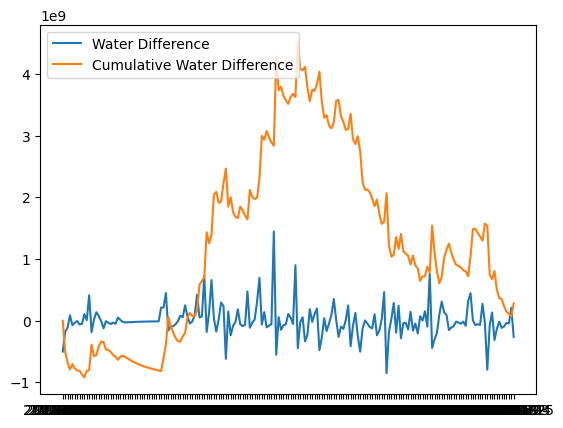

In [12]:
# Plot the water difference and cumulative water difference
plt.plot(merged['date'], merged['water_difference'])
plt.plot(merged['date'], merged['cumulative_water_difference'])
plt.legend(['Water Difference', 'Cumulative Water Difference'])
plt.show()


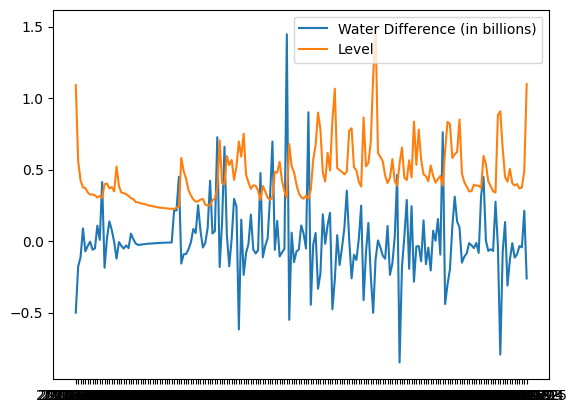

In [13]:
# Plot the water difference and the level against the date
plt.plot(merged['date'], merged['water_difference'] / 1000000000)
plt.plot(merged['date'], merged['avg_level'])
plt.legend(['Water Difference (in billions)', 'Level'])
plt.show()

As can be seen from the graph above, when we have a day with a large positive water difference, the water level rises shortly after. Likewise, when we have a day of negative rainfall, we see the water difference decrease as we'd expect. The next step will be to plot the differentiated water level as this will give us a better idea of the change in water level dependent upon the water difference.

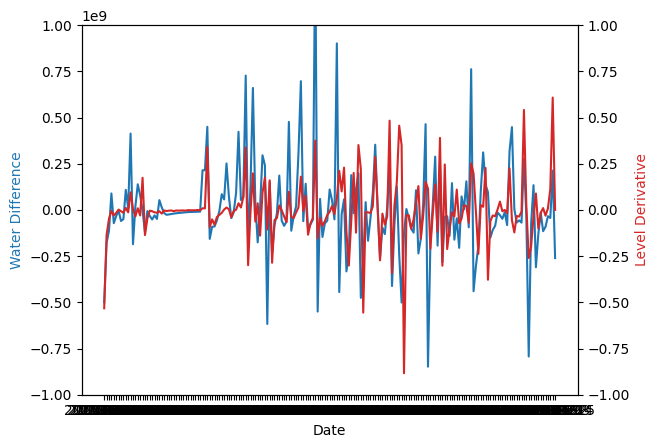

In [14]:
# Calculate the derivative of the water level
levelDerivative = [merged['avg_level'][i+1] - merged['avg_level'][i] for i in range(len(merged['avg_level'])-1)]
levelDerivative.append(0)
merged['level_derivative'] = levelDerivative

# Plot the water difference and the level derivative against the date with different axis scales
fig, ax1 = plt.subplots()
ax1.plot(merged['date'], merged['water_difference'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Water Difference', color='tab:blue')
ax1.set_ylim(-1000000000, 1000000000)
ax2 = ax1.twinx()
ax2.plot(merged['date'], merged['level_derivative'], color='tab:red')
ax2.set_ylabel('Level Derivative', color='tab:red')
ax2.set_ylim(-1, 1)
plt.show()

Damn that looks good :) love it when the data looks like it's doing what you expect it to do. The reason why the water difference is divided by a billion 

In [15]:
# Plot the level_derivative against the rainfall
merged.describe()


,gdf(m3/s),cdr(mm),min_level,avg_level,max_level,water_difference,cumulative_water_difference,level_derivative
count,189.000000,189.000000,189.000000,189.000000,189.000000,1.890000e+02,1.890000e+02,189.000000
mean,2.514138,5.330159,0.407751,0.462524,0.541778,1.130714e+05,1.224365e+09,0.000037
std,3.027556,6.797065,0.137684,0.199237,0.312965,2.579501e+08,1.503181e+09,0.169555
min,0.107000,0.000000,0.225000,0.225000,0.226000,-8.481910e+08,-9.194188e+08,-0.884000
25%,0.702000,0.300000,0.304000,0.327000,0.333000,-9.495585e+07,-1.964313e+08,-0.046000
50%,1.512000,2.700000,0.380000,0.410000,0.441000,-1.995840e+07,1.069468e+09,-0.007000
75%,3.198000,7.900000,0.468000,0.540000,0.619000,8.506845e+07,2.122888e+09,0.024000
max,21.610000,36.700000,1.041000,1.501000,1.771000,1.446485e+09,4.529751e+09,0.608000


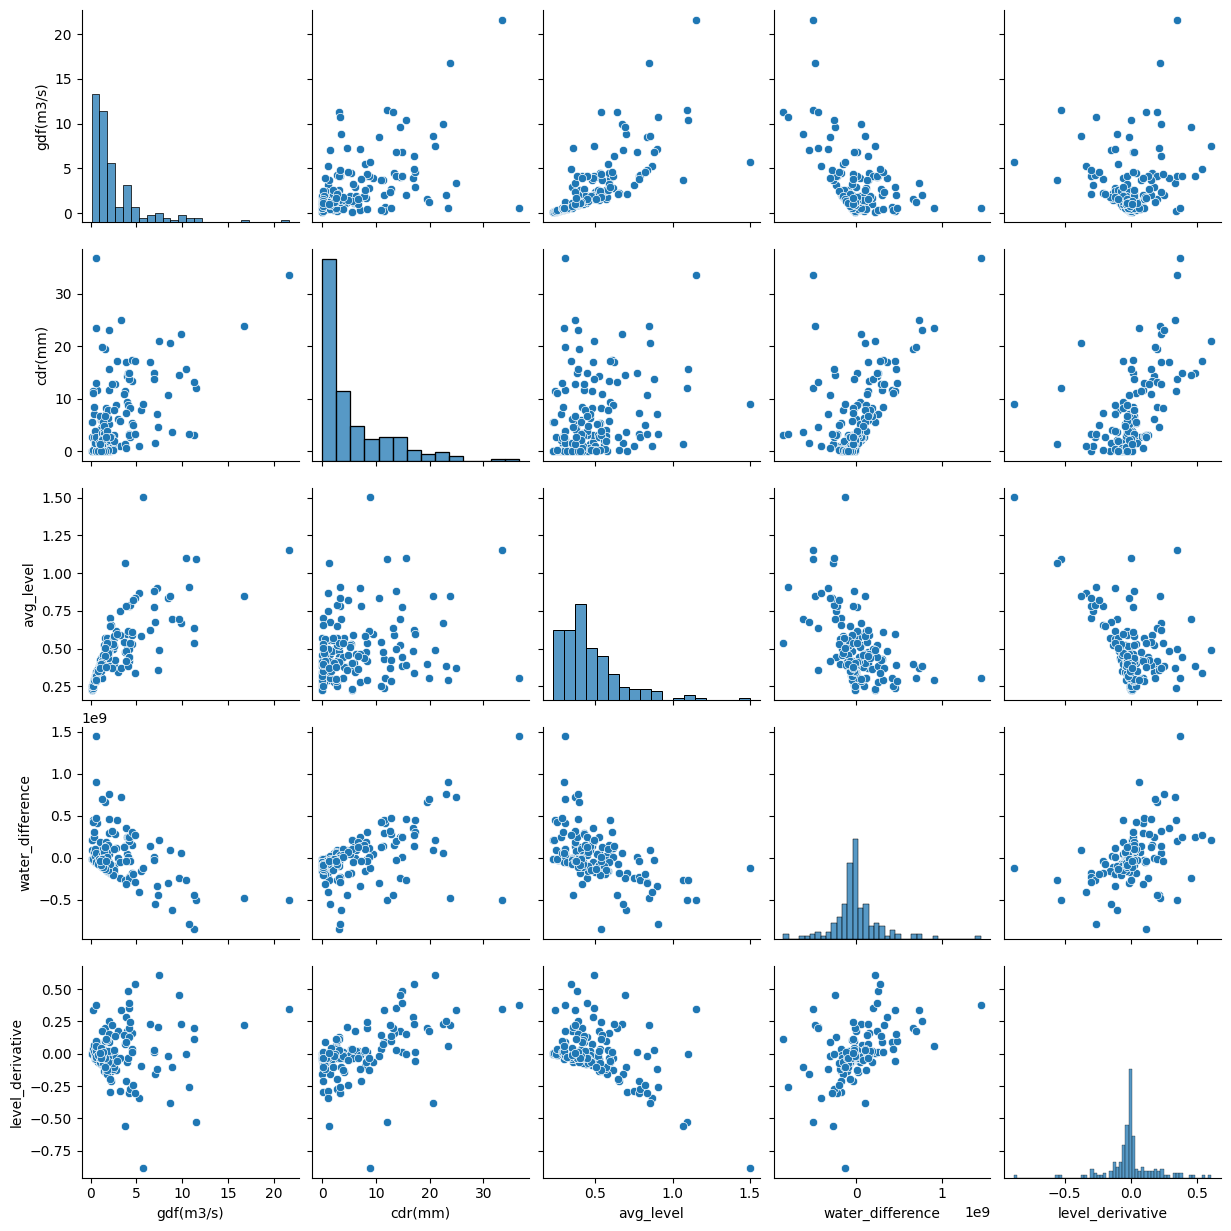

In [16]:
cols = ['gdf(m3/s)', 'cdr(mm)', 'avg_level', 'water_difference', 'level_derivative']
sns.pairplot(merged[cols], height=2.5)

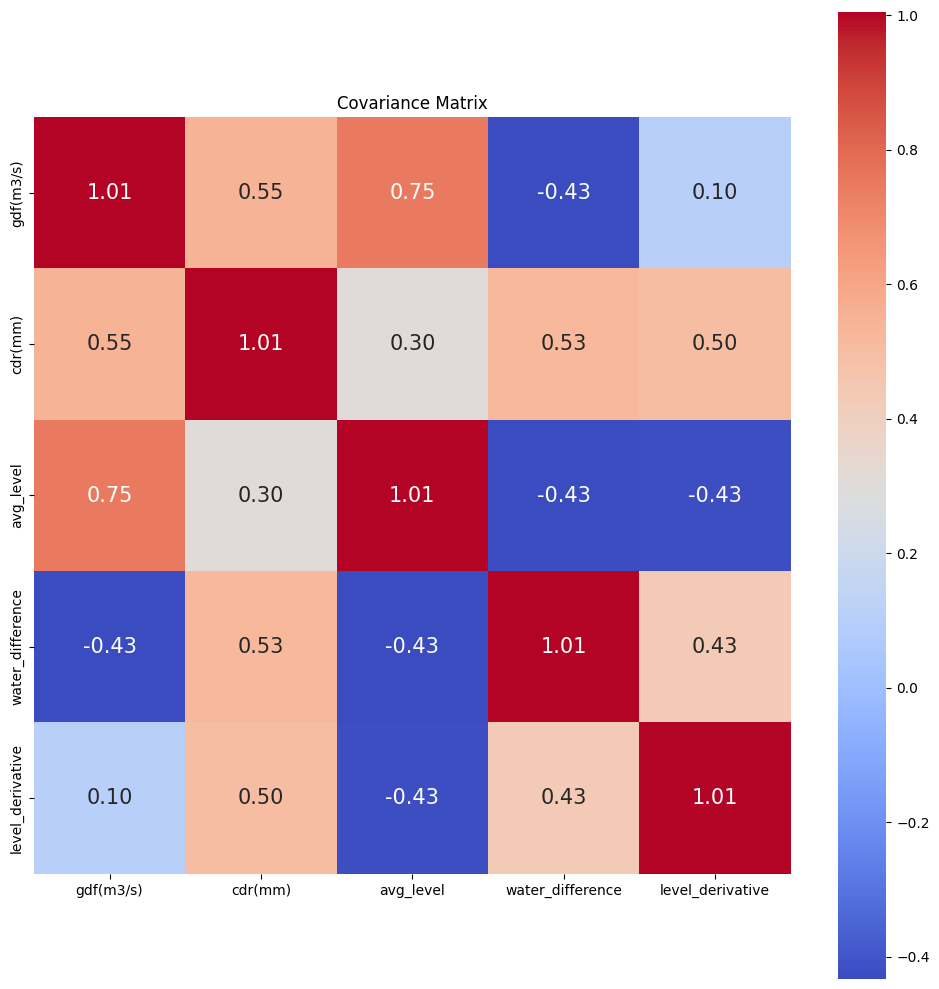

In [17]:
import sklearn
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_std = stdsc.fit_transform(merged[cols].values)
cov_mat = np.cov(X_std.T)
plt.figure(figsize=(10, 10))
hm = sns.heatmap(cov_mat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, cmap='coolwarm', yticklabels=cols, xticklabels=cols)
plt.title('Covariance Matrix')
plt.tight_layout()
plt.show()

Mention here about switching to the new data source - SEPA API!!

In [18]:
# Import the new data and create a dataframe
daily_flow = pd.read_csv('New Data/Daily_Averages/Daily_Mean_Flow_Rate.csv', delimiter=';')
daily_flow.rename(columns={'Value': 'Mean Flow (m3/s)'}, inplace=True)
daily_rain = pd.read_csv('New Data/Daily_Averages/Daily_Precipitation.csv', delimiter=';')
daily_rain.rename(columns={'Value': 'Daily Precipitation (mm)'}, inplace=True)
daily_level = pd.read_csv('New Data/Daily_Averages/Daily_Mean_Level.csv', delimiter=';')
daily_level.rename(columns={'Value': 'Mean Water Level (m)'}, inplace=True)

# Merge the 3 datasets into one
merged = pd.merge(daily_flow, daily_rain, on=['#Timestamp'])
merged = pd.merge(merged, daily_level, on=['#Timestamp'])
merged = merged.drop('Quality Code_x', axis=1)
merged = merged.drop('Quality Code_y', axis=1)
merged = merged.drop('Quality Code', axis=1)
merged.dropna(inplace=True)
merged.describe()

,Mean Flow (m3/s),Daily Precipitation (mm),Mean Water Level (m)
count,9388.000000,9388.000000,9388.000000
mean,2.571336,5.075852,0.461204
std,3.502277,15.217056,0.209103
min,0.000000,0.000000,0.175000
25%,0.504000,0.000000,0.306000
50%,1.251500,1.200000,0.404000
75%,3.147500,6.800000,0.561000
max,58.651000,949.600000,2.532000


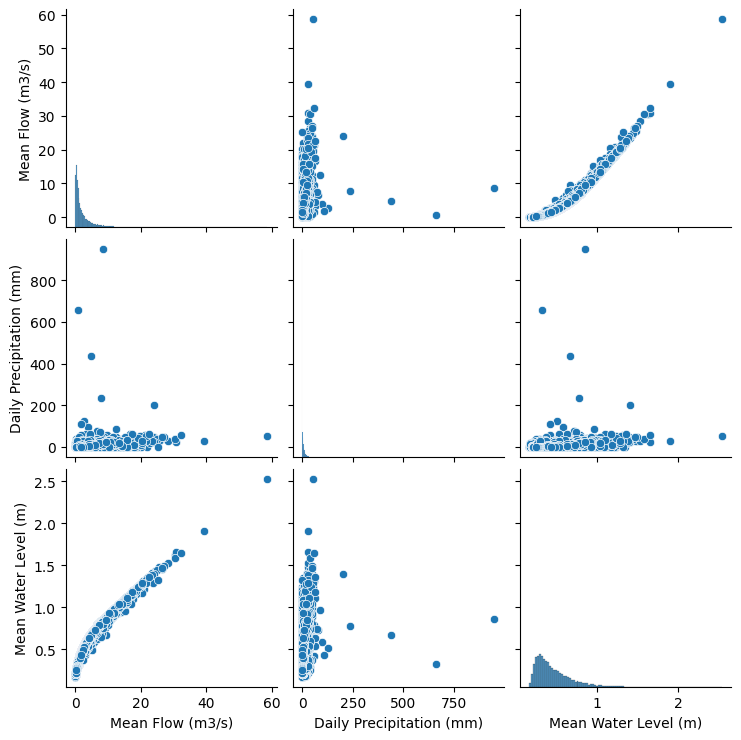

In [19]:
# remove days with daily precipitation above 200 mm
cols = ['Mean Flow (m3/s)', 'Daily Precipitation (mm)', 'Mean Water Level (m)']
sns.pairplot(merged[cols], height=2.5)

Now do the derivative of the water level and plot it against the water difference with the new data source.

/tmp/ipykernel_10005/1205034296.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(merged['#Timestamp'][0:1000], merged['Daily Precipitation (mm)'][0:1000])
/tmp/ipykernel_10005/1205034296.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(merged['#Timestamp'][0:1000], merged['Mean Water Level (m)'][0:1000]*50)


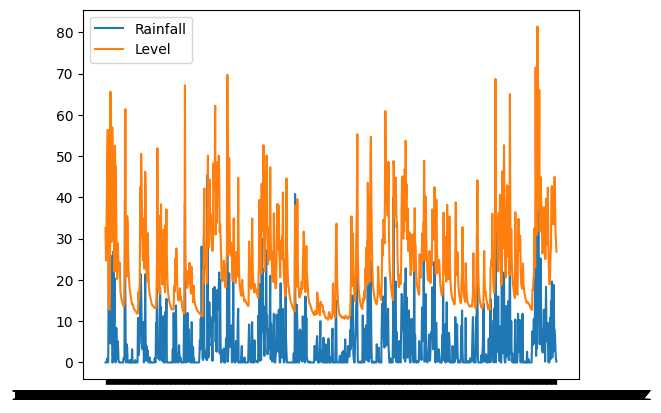

In [20]:
# Plot the rainfall and level against the date
plt.plot(merged['#Timestamp'][0:1000], merged['Daily Precipitation (mm)'][0:1000])
plt.plot(merged['#Timestamp'][0:1000], merged['Mean Water Level (m)'][0:1000]*50)
plt.legend(['Rainfall', 'Level'])
plt.show()


In [21]:
# Using SEPA's data means we can use the valyue of 0.72 for the conversion factor :)
waterDifference = merged['Daily Precipitation (mm)']*58500000*0.72 - merged['Mean Flow (m3/s)']*86400000
merged['water_difference'] = waterDifference
merged.describe()

,Mean Flow (m3/s),Daily Precipitation (mm),Mean Water Level (m),water_difference
count,9388.000000,9388.000000,9388.000000,9.388000e+03
mean,2.571336,5.075852,0.461204,-8.368562e+06
std,3.502277,15.217056,0.209103,6.130451e+08
min,0.000000,0.000000,0.175000,-2.919326e+09
25%,0.504000,0.000000,0.306000,-1.053324e+08
50%,1.251500,1.200000,0.404000,-3.261600e+07
75%,3.147500,6.800000,0.561000,5.112720e+07
max,58.651000,949.600000,2.532000,3.925636e+10


/tmp/ipykernel_10005/1759280165.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(merged['#Timestamp'][0:2000], merged['water_difference'][0:2000])


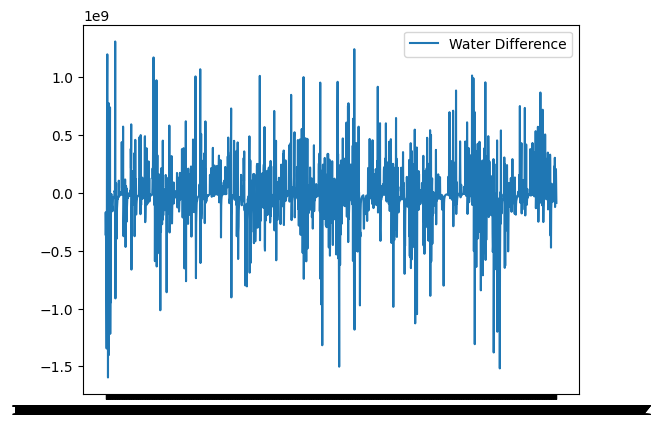

In [22]:
# Plot the water difference and cumulative water difference
plt.plot(merged['#Timestamp'][0:2000], merged['water_difference'][0:2000])
plt.legend(['Water Difference'])
plt.show()